In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [2]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_output/",
    "plot_config":     "VBSOS",
    "cut":             "sr",
    "model_version":   "v0c",
}

In [3]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

In [4]:
import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [5]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [6]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [8]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

In [9]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [10]:
scaler = pickle.load(open(f"{model_dir}/scaler_model.pkl", "rb"))
X_scaled = scaler.fit_transform(X)

In [11]:
# _ = plt.hist(W, bins=100)
# _ = plt.hist(W, bins=100, range=(0,2))

##  Balancing


In [12]:
config["test_size"] = 0.2
#config["val_size"]  = 0.5  ## test != val
config["val_size"]  = 0.0  ## test == val

X_train, X_temp, y_train, y_temp, W_train, W_temp , Wnn_train, Wnn_temp = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"])
#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [13]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_temp.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (40404, 18)
Test + Val dataset:  (10102, 18)


## SKLEARN - AVOVA F-Test

In [14]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_classif

import itertools

## This uses only public API, but is a real mess
#mask = [False for i in range (len(config["cols"]))]
#for varn  in range (len(config["cols"]) + 1):
#    a = SelectKBest(f_classif, k=varn)
#    a.fit(X_train, y_train)
#    mask_old = mask.copy()
#    mask = a.get_support()
#    mask_xor = [x ^ y for x,y in zip(mask, mask_old)]
#    print(varn, list(itertools.compress( config["cols"], mask_xor )))
        
## This uses a SelectKBest "private" member, but is faster and cleaner
selection = SelectKBest(f_classif, k=4)
selection.fit(X_train, y_train)
scores_df = pd.DataFrame({"score": selection.scores_, "varname": config["cols"]})


In [15]:
## visualize list of scores
#scores_df.sort_values(by=["score"], ascending=False)

<BarContainer object of 18 artists>

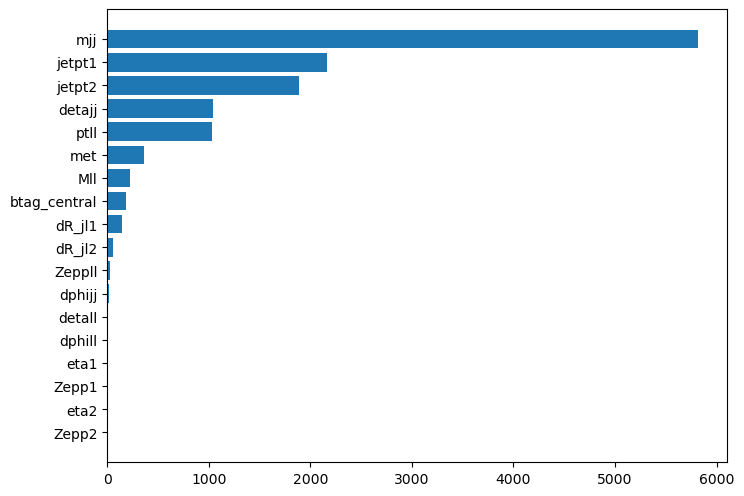

In [16]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

## visualize scores as barchart
s_df = scores_df.sort_values(by=["score"], ascending=True)
plt.barh(range(len(s_df["score"])), s_df["score"], tick_label=s_df["varname"])

## Keras model

In [17]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()

W1110 16:51:46.892674 140355826759488 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1900      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 22,201
Trainable params: 22,201
Non-trainable params: 0
_________________________________________________________________


# SHAP

In [18]:
## https://github.com/slundberg/shap

#!pip3 install --user --upgrade shap
# 0.35

In [19]:
import shap

shap.initjs()

In [20]:
index1 = [x for x in range(len(X_train))]
X_train_pd = pd.DataFrame(X_train, index=index1, columns=config["cols"])
index2 = [x for x in range(len(X_train), len(X_train) + len(X_temp))]
X_temp_pd = pd.DataFrame(X_temp, index=index2, columns=config["cols"])

In [21]:
shap_lenght = 1000
e = shap.DeepExplainer(model, X_train_pd.iloc[:shap_lenght,:])

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.
W1110 16:51:50.530678 140355826759488 deprecation_wrapper.py:119] From /eos/user/b/bpinolin/.local/lib/python3.7/site-packages/shap/explainers/tf_utils.py:28: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.



In [22]:
shap_values = e.shap_values(X_temp[:shap_lenght])

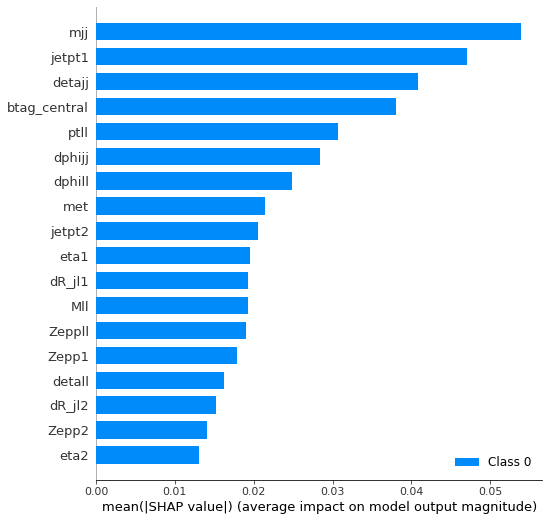

In [23]:
shap.summary_plot(shap_values, X_temp_pd.iloc[:,:], max_display=30)

# Altri plottini

shap.summary_plot(shap_values, X_temp_pd.iloc[:,:], max_display=30, show=False)
plt.savefig(os.path.join(model_dir, "SHAP.png"))

shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

index_event = 0
shap.force_plot(e.expected_value[0], shap_values[0][index_event], X_temp_pd.iloc[index_event,:])

index_event = 6
shap.force_plot(e.expected_value[0], shap_values[0][index_event], X_temp_pd.iloc[index_event,:])

shap.force_plot(e.expected_value, shap_values[0], X_temp_pd.iloc[:shap_lenght,:])

shap.dependence_plot("btag_central", shap_values[0], X_temp_pd.iloc[:shap_lenght,:])

shap.dependence_plot("btag_central", shap_values[0], X_temp_pd.iloc[:shap_lenght,:])

shap.summary_plot(shap_values[0], X_temp_pd.iloc[:shap_lenght,:])

import os

#notebook_name = 'Evaluate_ANOVA_SHAP.ipynb'
#file_name = 'Evaluate_ANOVA_SHAP.html'
#import sys
#!{sys.executable} -m jupyter nbconvert --to html $notebook_name --output /eos/home-d/dmapelli/latino/ML_classification/$file_name

#print(os.getcwd())
#print(os.listdir(os.getcwd()))
print("rsync Evaluate_ANOVA_SHAP.html lxplus.cern.ch:" + model_dir + "/Evaluate_ANOVA_SHAP.html; mv Evaluate_ANOVA_SHAP.html Evaluate_ANOVA_SHAP.html_old" )

#os.rename('Evaluate_ANOVA_SHAP.html', model_dir + "/Evaluate_ANOVA_SHAP.html")
#print(model_dir + "/Evaluate_ANOVA_SHAP.html")

### Evaluation

>>> Computing AUC...


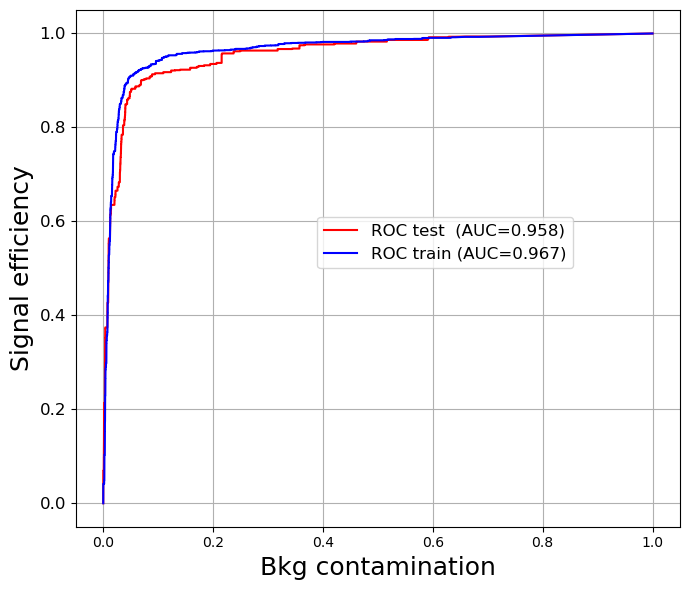

In [24]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

X_test = X_temp
W_test = W_temp
y_test = y_temp
pred_test  = model.predict(X_test,  batch_size=2048)
pred_train = model.predict(X_train, batch_size=2048)
auc_w_test  = roc_auc_score(y_test, pred_test,  sample_weight=W_test)
auc_w_train = roc_auc_score(y_train,pred_train, sample_weight=W_train)
fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test , sample_weight=W_test)
fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train, sample_weight=W_train)
#print("AUC score: " + str(auc))

fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

# ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="red")
ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()

## Some DNN distribution plots